### **Cell 1 – Import Libraries**

In [4]:
# Import all required Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Statsmodels for time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Prophet for forecasting
from prophet import Prophet

# Error metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

### **Cell 2 – Load and Prepare Data**

In [5]:
# Load the dataset (Update this path if needed)
path = r"C:\Users\HP\Documents\CalebOkoh_GrowthAnalyst_Assessment\sales_data_5_years.xlsx"

df = pd.read_excel(path)

# Clean column names and ensure proper data types
df = df.rename(columns={"Date": "Date", "Sales": "Sales"})
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Quick look at the first 5 rows
df.head()

,Date,Sales
0,2018-01-31,6496.71
1,2018-02-28,6763.28
2,2018-03-31,7986.67
3,2018-04-30,8763.56
4,2018-05-31,6443.81


### **Cell 3 – Dataset Info & Summary**

In [7]:
# Check dataset info
df.info()

# Check missing values
df.isnull().sum()

# Summary statistics
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    60 non-null     datetime64[ns]
 1   Sales   60 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB


,Date,Sales
count,60,60.000000
mean,2020-07-15 12:00:00,9845.345000
min,2018-01-31 00:00:00,3886.460000
25%,2019-04-22 12:00:00,7604.360000
50%,2020-07-15 12:00:00,9667.460000
75%,2021-10-07 18:00:00,12168.030000
max,2022-12-31 00:00:00,15975.550000
std,NaN,3127.999092


### **Cell 4 – Plot Raw Sales Data**

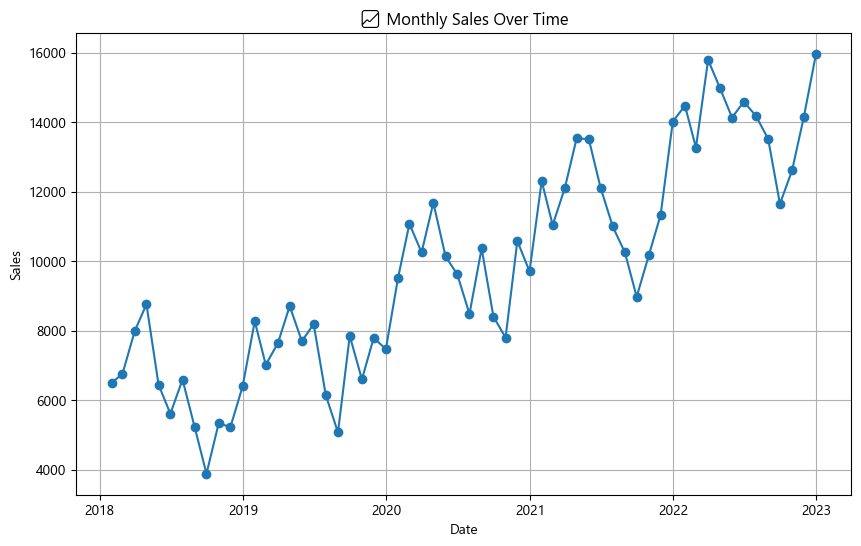

In [21]:
plt.rcParams['font.family'] = 'Segoe UI Emoji'  # Windows example
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Sales'], marker='o')
plt.title('📈 Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

### **Cell 5 – Decompose Time Series**

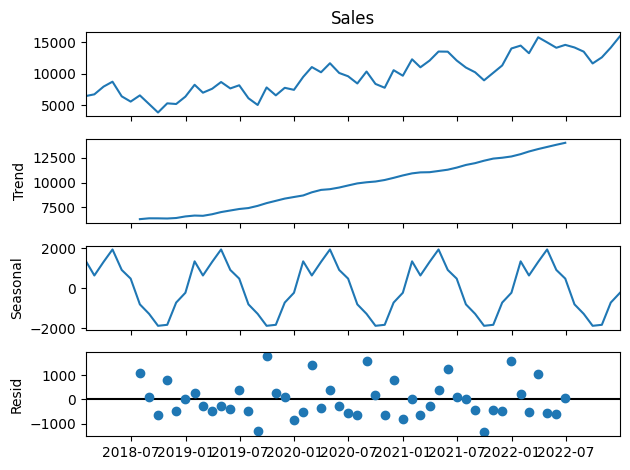

In [9]:
# Set Date as index and ensure monthly frequency
y_full = df.set_index("Date")["Sales"].asfreq("ME")

# Decompose into trend, seasonality, and residuals
decomp = seasonal_decompose(y_full, model="additive", period=12)
decomp.plot()
plt.show()

### **Cell 6 – Check Stationarity**

In [10]:
# First differencing to make the series stationary
y_diff = y_full.diff().dropna()

# Augmented Dickey-Fuller Test
adf_stat, pval, *_ = adfuller(y_diff)
print("ADF Statistic:", adf_stat)
print("p-value:", pval)
print("Stationary?", "YES" if pval <= 0.05 else "NO")

ADF Statistic: -6.927149189675925
p-value: 1.10780935435995e-09
Stationary? YES


### **Cell 7 – ACF & PACF Plots**

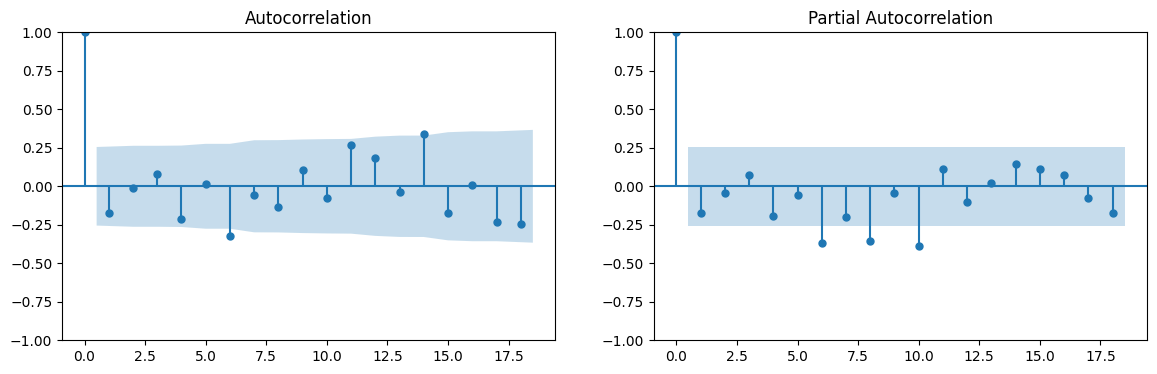

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(y_diff, ax=axes[0])
plot_pacf(y_diff, ax=axes[1])
plt.show()

### **Cell 8 – Train-Test Split**

In [12]:
# Split last 6 months for testing
split_n = 6
train = y_full.iloc[:-split_n]
test = y_full.iloc[-split_n:]

print("Train range:", train.index.min().date(), "→", train.index.max().date())
print("Test range:", test.index.min().date(), "→", test.index.max().date())

Train range: 2018-01-31 → 2022-06-30
Test range: 2022-07-31 → 2022-12-31


### **Cell 9 – ARIMA Forecast**

In [13]:
arima_model = ARIMA(train, order=(1,1,1))
arima_fit = arima_model.fit()

# Forecast for the test period
fr = arima_fit.get_forecast(steps=len(test))
arima_forecast = fr.predicted_mean
arima_confint = fr.conf_int()

# Store results
arima_forecast_df = pd.DataFrame({
    "Date": test.index,
    "Forecast": arima_forecast.values,
    "Lower": arima_confint.iloc[:, 0].values,
    "Upper": arima_confint.iloc[:, 1].values
})
arima_forecast_df

,Date,Forecast,Lower,Upper
0,2022-07-31,14512.787785,11793.109655,17232.465914
1,2022-08-31,14528.663898,10997.833608,18059.494188
2,2022-09-30,14525.587938,10288.439712,18762.736164
3,2022-10-31,14526.183898,9693.162278,19359.205518
4,2022-11-30,14526.068432,9161.498742,19890.638122
5,2022-12-31,14526.090803,8678.352117,20373.829489


### **Cell 10 – Prophet Forecast**

In [14]:
# Prophet needs 'ds' and 'y' column names
train_df = train.reset_index().rename(columns={"Date": "ds", "Sales": "y"})

prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
prophet_model.fit(train_df)

future = prophet_model.make_future_dataframe(periods=len(test), freq="ME")
prophet_fc = prophet_model.predict(future)

prophet_forecast_df = (
    prophet_fc.set_index("ds")
    .loc[test.index, ["yhat", "yhat_lower", "yhat_upper"]]
    .reset_index()
    .rename(columns={"ds": "Date", "yhat": "Forecast", "yhat_lower": "Lower", "yhat_upper": "Upper"})
)
prophet_forecast_df

10:08:19 - cmdstanpy - INFO - Chain [1] start processing
10:08:21 - cmdstanpy - INFO - Chain [1] done processing


,Date,Forecast,Lower,Upper
0,2022-07-31,13088.842081,12305.574403,13898.262043
1,2022-08-31,12268.490954,11376.040039,13039.576160
2,2022-09-30,12530.996000,11673.827784,13322.330209
3,2022-10-31,12677.377786,11821.988074,13514.545288
4,2022-11-30,13671.120014,12854.176445,14534.586621
5,2022-12-31,14382.424952,13572.518647,15202.238980


### **Cell 11 – Forecast Accuracy Metrics**

In [15]:
# Custom RMSE & MAPE
def rmse(a, f):
    return np.sqrt(np.mean((np.asarray(a) - np.asarray(f)) ** 2))

def mape(a, f):
    a, f = np.asarray(a), np.asarray(f)
    denom = np.where(a == 0, np.finfo(float).eps, a)
    return np.mean(np.abs((a - f) / denom)) * 100

actual = test.values.ravel()

# ARIMA metrics
arima_mae = mean_absolute_error(actual, arima_forecast_df["Forecast"])
arima_rmse = rmse(actual, arima_forecast_df["Forecast"])
arima_mape = mape(actual, arima_forecast_df["Forecast"])

# Prophet metrics
prophet_mae = mean_absolute_error(actual, prophet_forecast_df["Forecast"])
prophet_rmse = rmse(actual, prophet_forecast_df["Forecast"])
prophet_mape = mape(actual, prophet_forecast_df["Forecast"])

print(f"ARIMA(1,1,1) → MAE: {arima_mae:.2f} RMSE: {arima_rmse:.2f} MAPE: {arima_mape:.2f}%")
print(f"Prophet → MAE: {prophet_mae:.2f} RMSE: {prophet_rmse:.2f} MAPE: {prophet_mape:.2f}%")

ARIMA(1,1,1) → MAE: 1321.69 RMSE: 1594.11 MAPE: 10.20%
Prophet → MAE: 894.59 RMSE: 1026.48 MAPE: 6.40%


### **Cell 12 – Plot ARIMA vs Prophet**

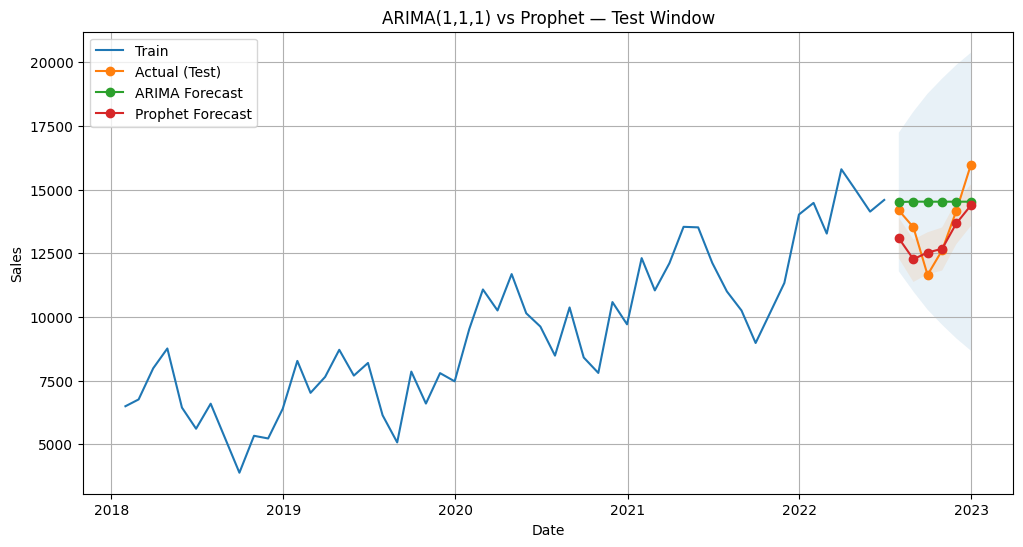

In [16]:
plt.figure(figsize=(12, 6))

# Actual data
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, marker="o", label="Actual (Test)")

# ARIMA
plt.plot(arima_forecast_df["Date"], arima_forecast_df["Forecast"], marker="o", label="ARIMA Forecast")
plt.fill_between(arima_forecast_df["Date"], arima_forecast_df["Lower"], arima_forecast_df["Upper"], alpha=0.1)

# Prophet
plt.plot(prophet_forecast_df["Date"], prophet_forecast_df["Forecast"], marker="o", label="Prophet Forecast")
plt.fill_between(prophet_forecast_df["Date"], prophet_forecast_df["Lower"], prophet_forecast_df["Upper"], alpha=0.1)

plt.title("ARIMA(1,1,1) vs Prophet — Test Window")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.show()

### **Cell 13 – Next Quarter Forecast**

In [17]:
# ARIMA Next 3 Months
arima_full = ARIMA(y_full, order=(1,1,1)).fit()
fr3 = arima_full.get_forecast(steps=3)
arima_next_qtr_df = pd.DataFrame({
    "Date": pd.date_range(start=y_full.index[-1] + pd.DateOffset(months=1), periods=3, freq="ME"),
    "Forecast": fr3.predicted_mean.values,
    "Lower": fr3.conf_int().iloc[:, 0].values,
    "Upper": fr3.conf_int().iloc[:, 1].values
})

# Prophet Next 3 Months
df_p = df.rename(columns={"Date": "ds", "Sales": "y"})
prophet_full = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
prophet_full.fit(df_p)
future_3_p = prophet_full.make_future_dataframe(periods=3, freq="ME")
fc_p_full = prophet_full.predict(future_3_p)
prophet_next_qtr_df = (
    fc_p_full[fc_p_full["ds"] > df_p["ds"].max()][["ds", "yhat", "yhat_lower", "yhat_upper"]]
    .rename(columns={"ds": "Date", "yhat": "Forecast", "yhat_lower": "Lower", "yhat_upper": "Upper"})
    .reset_index(drop=True)
)

10:14:16 - cmdstanpy - INFO - Chain [1] start processing
10:14:17 - cmdstanpy - INFO - Chain [1] done processing


### **Cell 14 – Plot Next Quarter**

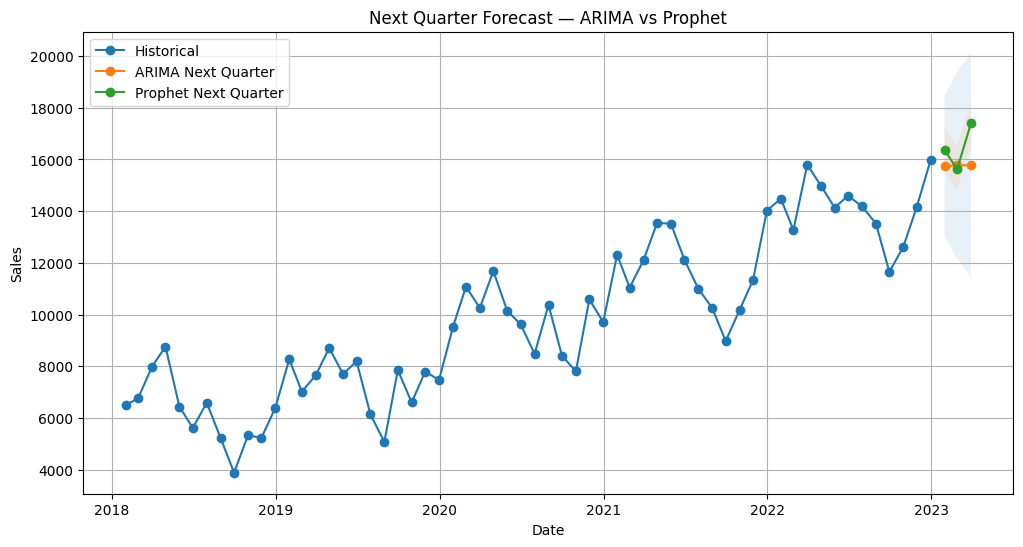

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(y_full.index, y_full.values, marker="o", label="Historical")

# ARIMA next 3
plt.plot(arima_next_qtr_df["Date"], arima_next_qtr_df["Forecast"], marker="o", label="ARIMA Next Quarter")
plt.fill_between(arima_next_qtr_df["Date"], arima_next_qtr_df["Lower"], arima_next_qtr_df["Upper"], alpha=0.1)

# Prophet next 3
plt.plot(prophet_next_qtr_df["Date"], prophet_next_qtr_df["Forecast"], marker="o", label="Prophet Next Quarter")
plt.fill_between(prophet_next_qtr_df["Date"], prophet_next_qtr_df["Lower"], prophet_next_qtr_df["Upper"], alpha=0.1)

plt.title("Next Quarter Forecast — ARIMA vs Prophet")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.show()

### **Cell 15 – Scenario Analysis**

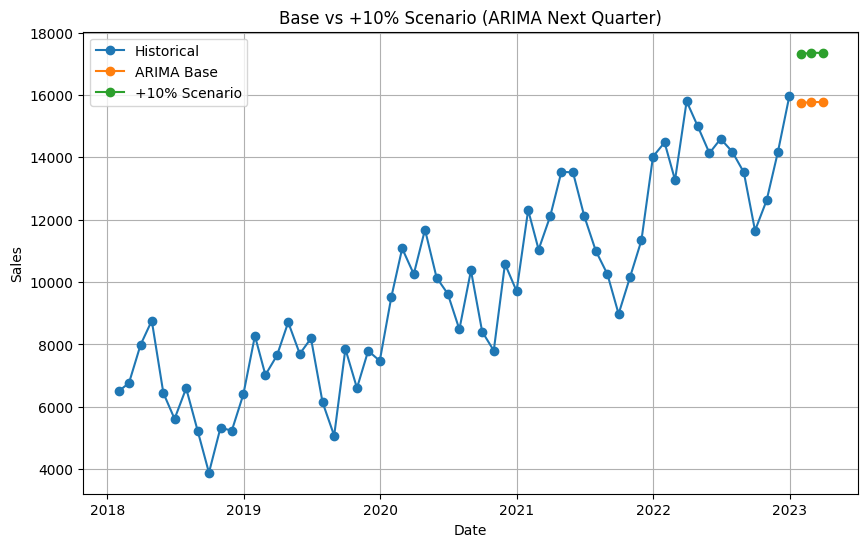

In [19]:
scenario_df = arima_next_qtr_df.copy()
scenario_df["Scenario_Forecast"] = scenario_df["Forecast"] * 1.10  # +10% growth

plt.figure(figsize=(10, 6))
plt.plot(y_full.index, y_full.values, marker="o", label="Historical")
plt.plot(arima_next_qtr_df["Date"], arima_next_qtr_df["Forecast"], marker="o", label="ARIMA Base")
plt.plot(scenario_df["Date"], scenario_df["Scenario_Forecast"], marker="o", label="+10% Scenario")
plt.title("Base vs +10% Scenario (ARIMA Next Quarter)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.show()

### **Cell 16 – Save Results**

In [20]:
arima_forecast_df.to_csv("arima_backtest_forecast.csv", index=False)
prophet_forecast_df.to_csv("prophet_backtest_forecast.csv", index=False)
arima_next_qtr_df.to_csv("arima_next_quarter.csv", index=False)
prophet_next_qtr_df.to_csv("prophet_next_quarter.csv", index=False)
print(" Saved CSVs to working directory.")

 Saved CSVs to working directory.
